# Statistical analysis II

This set of notes aims to build upon the first set on statistical analysis. We look at more complicated statistical models as well as further properties of the statistical methods we discussed in the first set.

In [1]:
# imports
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

sns.set_style(  
    "whitegrid",  
    {  
        'legend.frameon': True,  
    }  
)
matplotlib.rc('figure', figsize=(14, 8))

## Autocorrelation and Autoregressive (AR) models

An *autoregressive* or $AR(p)$ model is one which is a regression of a time series on its past values (its lags), satisfying the following conditions:
1. The expected value of the time series is constant and finite at all times, i.e. $\mathbb{E}[y_t]=\mu$, $\mu<\infty\;\forall t$
2. The variance of the time series is constant and finite for all time periods.
3. For $\lambda$ constant, $|\lambda|<\infty$, require $\text{cov}(y_t,y_{t-s})=\lambda$, where $t=1,2,...,T$, $s=0,\pm 1,\pm2,...,\pm T$. In other words, the covariance of the time series with itself for a fixed number of periods in either the future or the past is constant and finite for all time periods.

Note that condition (3) implies (2). For example, let $x_t$ be a time series. Then the $AR(1)$ model is
$$
x_t=b_0+b_1x_{t-1}+\epsilon_t
$$
where $\epsilon_t$ is an error term. Thus an $AR(p)$ model takes the form
$$
x_t=b_0+b_1x_{t-1}+b_2x_{t-2} +...+b_px_{t-p}+\epsilon_t\,.
$$

Let us now try to simulate and draw data samples from an $AR(3)$ process.

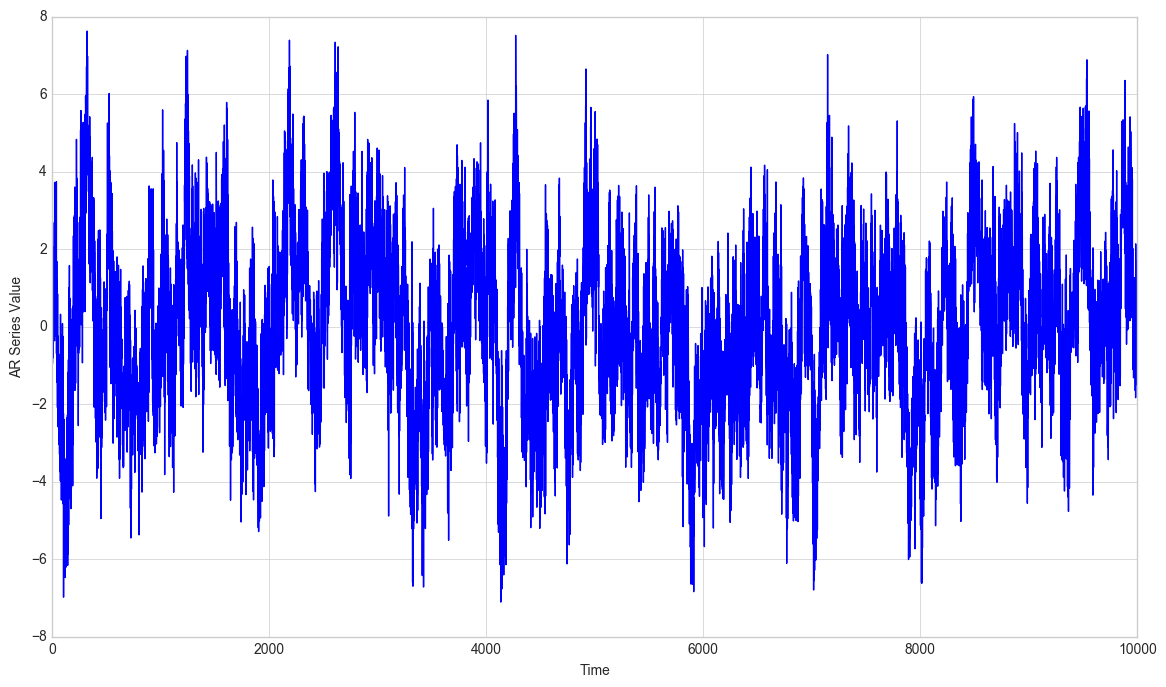

In [2]:
import statsmodels.tsa as tsa

# ensures experiment runs the same every time
np.random.seed(100)

# This function simluates an AR process, generating a new value based on historial values,
# autoregressive coefficients b1 ... bk, and some randomness.
def AR(b, X, mu, sigma):
    l = min(len(b)-1, len(X))
    b0 = b[0]
    
    return b0 + np.dot(b[1:l+1], X[-l:]) + np.random.normal(mu, sigma)

b = np.array([0, 0.8, 0.1, 0.05])
X = np.array([1])

mu = 0
sigma = 1

for i in range(10000):
    X = np.append(X, AR(b, X, mu, sigma))
    
plt.plot(X)
plt.xlabel('Time')
plt.ylabel('AR Series Value');

Autoregressive processes will tend to have more extreme values than data drawn from, say, a normal distribution. This is because the value at each time point is influenced by its recent values. If the series randomly jumps up, it is more likely to stay up than a non-autoregressive series. This is known as 'fat-tailledness' (fat-tailed distribution) because the extremes on the pdf will be fatter than in a normal distribution.

Tail risk is present in finance due to the fact that tail events do occur, albeit infrequently. There is a difficulty in accounting for them in models and if we suspect that a process is autoregressive, we should expect risk from tail events and adjust accordingly. Note however that tail risk does not only come from AR models.

In [3]:
def compare_tails_to_normal(X):
    # Define matrix to store comparisons
    A = np.zeros((2,4))    
    for k in range(4):             
        #stores tail probabilities of the sample series vs a normal series
        A[0, k] = len(X[X > (k + 1)]) / float(len(X)) # Estimate tails of X        
        A[1, k] = 1 - stats.norm.cdf(k + 1) # Compare to Gaussian distribution
    print 'Frequency of std events in X \n1: %s\t2: %s\t3: %s\t4: %s' % tuple(A[0])
    print 'Frequency of std events in a normal process \n1: %s\t2: %s\t3: %s\t4: %s' % tuple(A[1])
    return A

compare_tails_to_normal(X);

Frequency of std events in X 
1: 0.327567243276	2: 0.185481451855	3: 0.0909909009099	4: 0.035796420358
Frequency of std events in a normal process 
1: 0.158655253931	2: 0.0227501319482	3: 0.00134989803163	4: 3.16712418331e-05


Note that since AR processes are tail heavy and have a non-normal distribution, our usual estimates of variance on them will be wrong. This further affects statistical quantities such as confidence intervals and p-values, which is problematic.

In [4]:
def compute_unadjusted_interval(X):
    T = len(X)
    # Compute mu and sigma MLE
    mu = np.mean(X)
    sigma = np.std(X)
    # Compute the 95% c.i. bounds using standard error
    lower = mu - 1.96 * (sigma/np.sqrt(T))
    upper = mu + 1.96 * (sigma/np.sqrt(T))
    return lower, upper

# We'll make a function that returns true when the computed bounds contain 0
def check_unadjusted_coverage(X):
    l, u = compute_unadjusted_interval(X)
    # Check to make sure l <= 0 <= u
    if l <= 0 and u >= 0:
        return True
    else:
        return False
    
def simululate_AR_process(b, T):
    X = np.array([1])

    mu = 0
    sigma = 1

    for i in range(T):
        X = np.append(X, AR(b, X, mu, sigma))
        
    return X

trials = 1000
outcomes = np.zeros((trials, 1))

for i in range(trials):
    #note these are the same values we used to generate the initial AR array
    Z = simululate_AR_process(np.array([0, 0.8, 0.1, 0.05]), 100)
    if check_unadjusted_coverage(Z):
        # The interval contains 0, the true value
        outcomes[i] = 1
    else:
        outcomes[i] = 0
        
np.sum(outcomes) / trials

0.193

This result is vastly less than the expected 0.95. This is due to the AR series fluctuating a lot more, so the confidence intervals are smaller than they should be and do not contain the correct value nearly enough.

One attempt to estimate variance on an AR series is using the *Newey-West estimation*.

How do we identify AR behaviour? In order to determine the order $p$ of an $AR(p)$ model, we look at autocorrelations of the time series. These are correlations of the series with its past values. The $k$th order autocorrelation is
$$
\rho_k=\frac{\text{cov}(x_t,x_{t-k})}{\sigma_x^2}=\frac{\mathbb{E}[(x_t-\mu)(x_{t-k}-\mu)]}{\sigma_x^2}\,,
$$
where $k$ represents the number of periods lagged. We cannot directly observe the autocorrelations so we estimate them as
$$
\hat{\rho}_k=\frac{\sum_{t=k+1}^T[(x_t-\bar{x})(x_{t-k}-\bar{x})]}{\sum_{t=1}^T(x_t-\bar{x})^2}\,.
$$

A pair of tools called the autocorrelation function (ACF) and the partial autocorrelation function (PACF) allows us to do this. The PACF controls for shorter lags. Together, they compute the sample autocorrelations for us, allowing us to determine the value of $p$.

Autocorrelations:
[ 1.          0.57070553  0.58001725  0.88553976  0.55669882  0.57640436
  0.78307405  0.54759415  0.55254723  0.70158722  0.53082572  0.52673077
  0.62850967  0.50091633  0.48541475  0.56544198  0.46391848  0.45390828
  0.51491108  0.43375521  0.43938017  0.46783793  0.40843913  0.42270738
  0.42566802  0.38298857  0.38379558  0.40029717  0.36548704  0.36088258
  0.37743521  0.34745858  0.34065687  0.35239327  0.33194099  0.31758452
  0.33113111  0.31688646  0.2818213   0.31237461  0.31252031]

Partial Autocorrelations:
[ 1.          0.57127624  0.37827414  0.80672256  0.00162478  0.00490887
 -0.04497956  0.04013524 -0.05301909  0.00706455 -0.00528104  0.0051476
 -0.03421094 -0.03637203 -0.06841025  0.00396849 -0.02433695  0.03906542
  0.02344142  0.02958713  0.07306916 -0.01201434  0.00279546  0.01328444
 -0.00679875 -0.01547705 -0.09186641  0.05847768  0.03298422  0.04395628
 -0.01605778  0.00286143 -0.00734411 -0.01496441  0.01152254 -0.01185183
  0.01895763  0.01

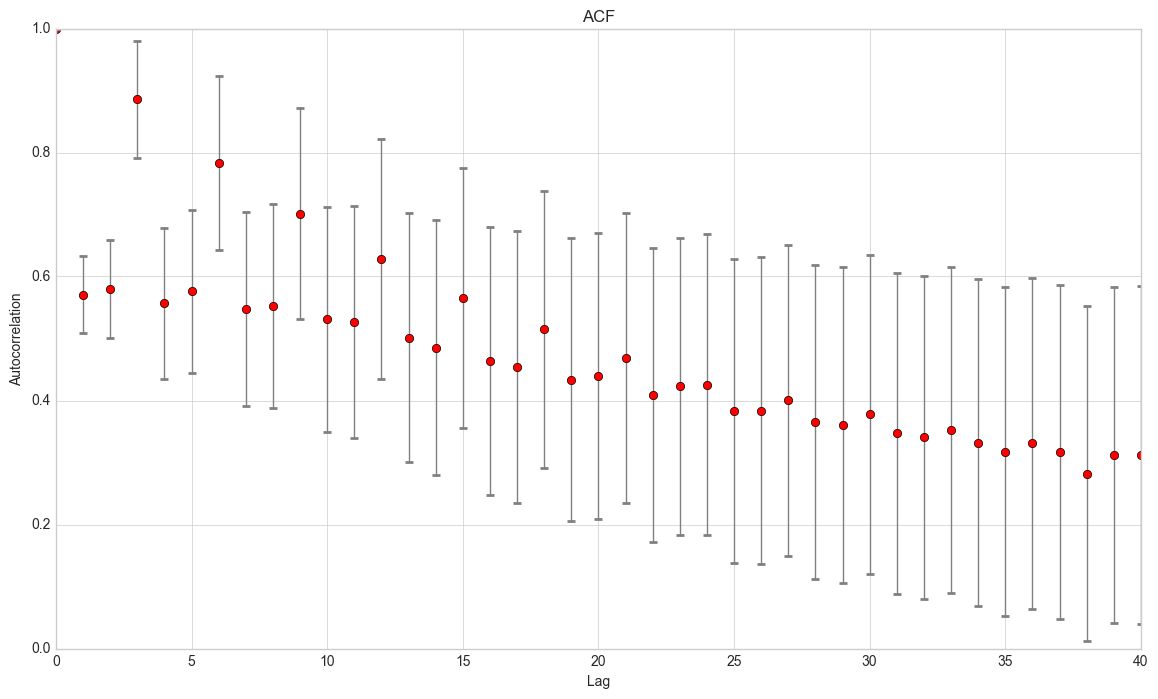

In [5]:
from statsmodels.tsa.stattools import acf, pacf
X = simululate_AR_process(np.array([0, 0.8, 0.1, 0.05]), 1000)
# We'll choose 40 lags. This is a bit arbitrary, but you want to include all the lags you think might
# feasibly impact the current value.
nlags = 40
# Note, this will produce nlags + 1 values, as we include the autocorrelation of
# X[-1] with X[-1], which is trivially 1.
# The reason this is done is because that is the 0th spot in the array and corresponds
# to the 0th lag of X[(-1)-0].

# We have to set a confidence level for our intervals, we choose the standard of 95%,
# corresponding with an alpha of 0.05.
X_acf, X_acf_confs = acf(X, nlags=nlags, alpha=0.05)
X_pacf, X_pacf_confs = pacf(X, nlags=nlags, alpha=0.05)
print 'Autocorrelations:\n' + str(X_acf) + '\n'
print 'Partial Autocorrelations:\n' + str(X_pacf)

def plot_acf(X_acf, X_acf_confs, title='ACF'):
    # The confidence intervals are returned by the functions as (lower, upper)
    # The plotting function needs them in the form (x-lower, upper-x)
    errorbars = np.ndarray((2, len(X_acf)))
    errorbars[0, :] = X_acf - X_acf_confs[:,0]
    errorbars[1, :] = X_acf_confs[:,1] - X_acf

    plt.plot(X_acf, 'ro')
    plt.errorbar(range(len(X_acf)), X_acf, yerr=errorbars, fmt='none', ecolor='gray', capthick=2)
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.title(title);
plot_acf(X_acf, X_acf_confs)

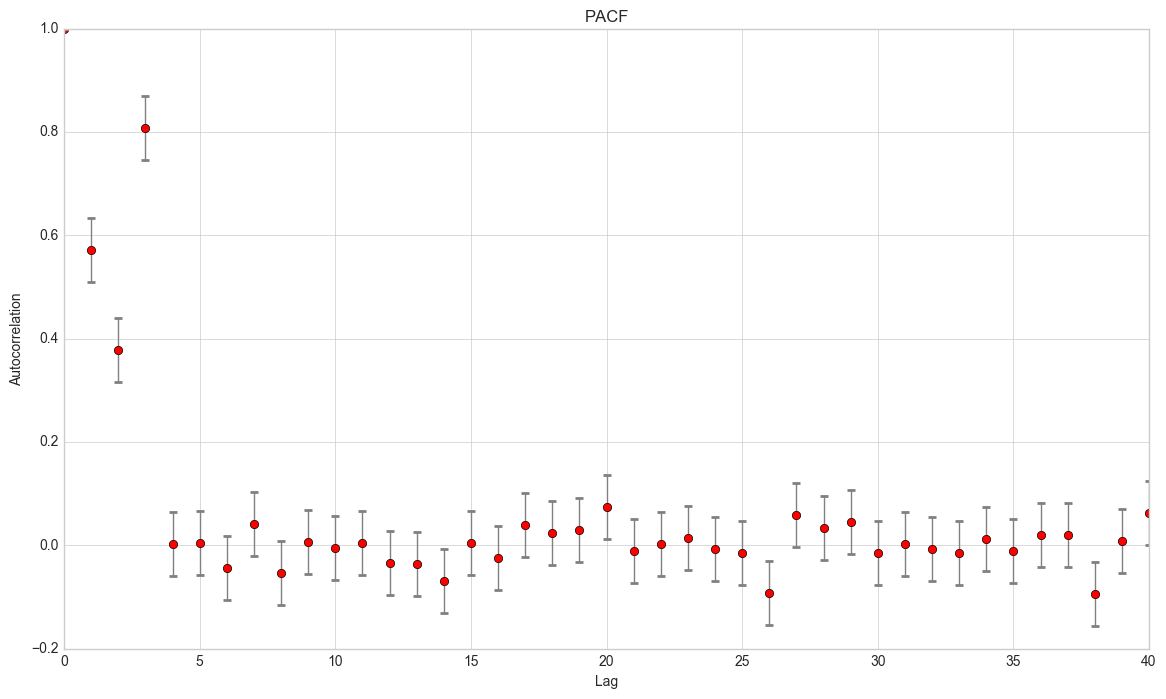

In [6]:
plot_acf(X_pacf, X_pacf_confs, title='PACF')

Notice how for the PACF, only the first three lags are the ones that appear to be significantly different from 0, which makes sense because we directly constructed an AR model of order 3. However, these results may vary for each random series generated in this notebook.

In a real-world time series, we use these plots to determine the order of our model. We then attempt to fit a model using a maximum likelihood function. Let us do this now.

Parameters
[ 0.01001762  0.04631952  0.06669125  0.84444655 -0.02662476  0.07031018
 -0.03883539  0.05362627 -0.06257934  0.03183551  0.02255835  0.06366225
 -0.02663838 -0.00824025 -0.09032174 -0.02259851 -0.05894006 -0.03575162
  0.01899755  0.0265497   0.08158745 -0.00494997]
Standard Error
[ 0.03210283  0.03228516  0.03221285  0.03226938  0.04224386  0.04226218
  0.04228528  0.04223737  0.04222499  0.04230633  0.04232241  0.04227582
  0.04230175  0.04232492  0.04221253  0.04221065  0.04218858  0.04214434
  0.04212185  0.03217742  0.03220652  0.03227438]


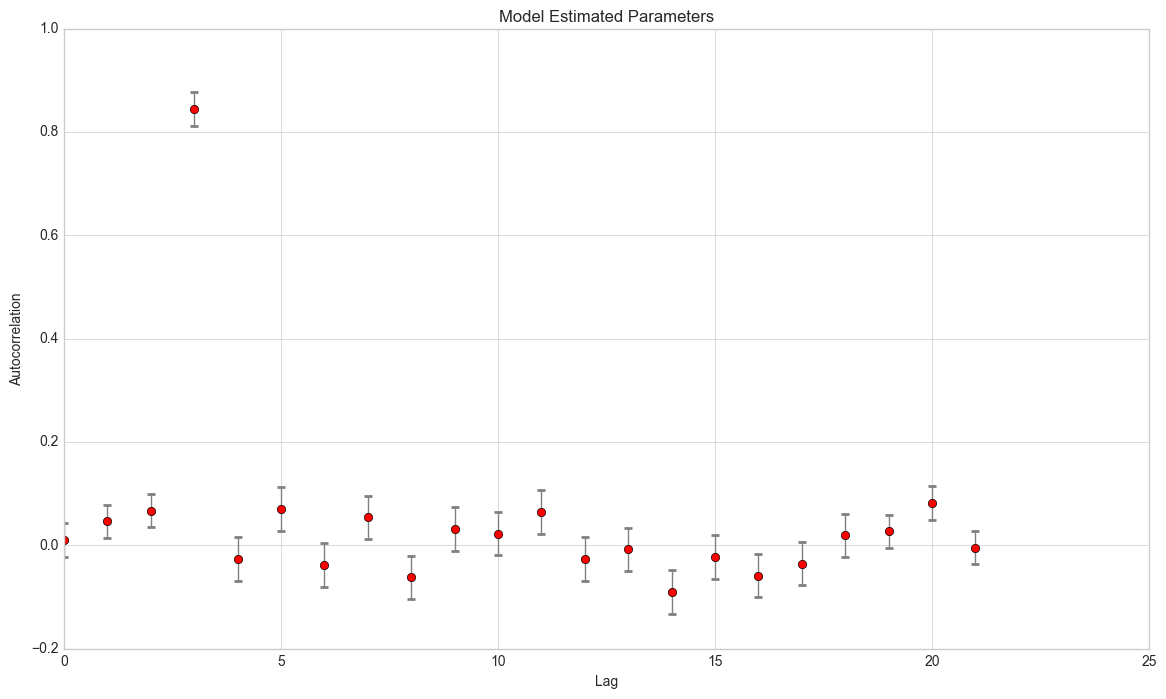

In [7]:
# Construct an unfitted model
model = tsa.api.AR(X)
# Fit it
model = model.fit()

print 'Parameters'
print model.params
print 'Standard Error'
print model.bse

# To plot this we'll need to format a confidence interval 2D array like the previous functions returned
# Here is some quick code to do that
model_confs = np.asarray((model.params - model.bse, model.params + model.bse)).T

plot_acf(model.params, model_confs, title='Model Estimated Parameters')

We see that our model estimated quite a few parameters, in fact, too many, since the data is an AR(3) process. The reason that AR models will estimate many more lags than there actually is is due to indirect dependency: if $X_t$ depends on $X_{t-1}$, then it will to a lesser extent depend on $X_{t-2}$ as well. When there is more than one lag in the data generating process, this leads to complex harmonic structures that gets picked up in simple stimation.

We do not want to model a data series with too many parameters; this will lead to overfitting. Observing the ACF and PACF indicates that only the first 3 lags may be useful. However, we will expand the number of lags to 10 to double-check our initial data. We will use information criterion, specifically *Akaike Information Criterion* (AIC) and *Bayes Information Criterion* (BIC) to decide the correct number of parameters.

The AIC is defined as follows. Suppose we have a statistical mdoel $M$ of some data $x$. Let $k$ be the number of estimated parameters in the model. Let $\hat{L}$ be the maximum value of the likelihood function for the model, i.e. $\hat{L}=\mathbb{P}(x|\hat{\theta},M)$ where $\hat{\theta}$ are the parameter values that maximise the likelihood function. Then the AIC value of the model is
$$
\text{AIC}=2k-2\ln(\hat{L})\,.
$$
The AIC rewards goodness of fit (as assessed by the likelihood function), but it also includes a penalty that is an increasing function of the number of estimated parameters.

The BIC is defined as
$$
\text{BIC}=k\ln(n)-2\ln(\hat{L})\,,
$$
where $n$ is the number of data points in $x$, and all other variables defined as above. The two are closely related and measure similar properties of the model.

To interpret the IC, we compute the *relative likelihood* of each model $i$
$$
l = e^{(IC_\min-IC_i)/2}\,.
$$
This quantity represents the number of times model $i$ is likely to minimise information loss, compared to the minimum AIC model.

In [8]:
N = 10
AIC = np.zeros((N, 1))

for i in range(N):
    model = tsa.api.AR(X)
    model = model.fit(maxlag=(i+1))
    AIC[i] = model.aic
    
AIC_min = np.min(AIC)
model_min = np.argmin(AIC)

print 'Relative Likelihoods'
print np.exp((AIC_min-AIC) / 2)
print 'Number of parameters in minimum AIC model %s' % (model_min+1)

Relative Likelihoods
[[ 0.54739169]
 [ 0.59052713]
 [ 0.99861675]
 [ 0.997749  ]
 [ 0.99628437]
 [ 0.99619915]
 [ 0.9960884 ]
 [ 1.        ]
 [ 0.99850924]
 [ 0.99809322]]
Number of parameters in minimum AIC model 8


In [9]:
N = 10
BIC = np.zeros((N, 1))

for i in range(N):
    model = tsa.api.AR(X)
    model = model.fit(maxlag=(i+1))
    BIC[i] = model.bic
    
BIC_min = np.min(BIC)
model_min = np.argmin(BIC)

print 'Relative Likelihoods'
print np.exp((BIC_min-BIC) / 2)
print 'Number of parameters in minimum BIC model %s' % (model_min+1)

Relative Likelihoods
[[ 0.5508575 ]
 [ 0.59280494]
 [ 1.        ]
 [ 0.99666667]
 [ 0.99274501]
 [ 0.99020386]
 [ 0.98763995]
 [ 0.98905709]
 [ 0.9851272 ]
 [ 0.98226451]]
Number of parameters in minimum BIC model 3


The AIC model estimates that the 8 parameter model is most likely, whereas the BIC estimates 3. We always want to choose the model with the fewest parameters, so we go with 3.

Lastly, we can look at the model's residual behaviour. Note that the AIC and BIC already do this to some extent, as it measures the amount of information left (in the residuals) after the model has made its predictions.

If all has passed, the next steps would be testing the model out of sample, and then using it to make predictions on your data.

In [10]:
model = tsa.api.AR(X)
model = model.fit(maxlag=3)

from statsmodels.stats.stattools import jarque_bera

score, pvalue, _, _ = jarque_bera(model.resid)

if pvalue < 0.10:
    print 'We have reason to suspect the residuals are not normally distributed.'
else:
    print 'The residuals seem normally distributed.'

The residuals seem normally distributed.


## Estimation of covariance matrices
Sample covariance measurements (using sample data to find out how two populations move with respect to one another) are susceptible to variation over time. Additionally, the accuracy of a covariance matrix decreases as the number of variables increases without correspondingly a decrease in sample size. This section looks at how we can estimate the covariance matrix.

In [11]:
# imports
from sklearn import covariance

Recall that the covariance of random variables $X$ wrt to $Y$ is
$$
\text{cov}(X,Y)=\mathbb{E}[(X-\mathbb{E}[X])(Y-\mathbb{E}[Y])]\,,
$$
and the covariance of $X$ with itself is simply its variance.

For $N$ assets $X_1,...,X_N$, the covariance matrix $\Sigma$ is a symmetric $N\times N$ matrix where
$$
\Sigma_{ij}=\text{cov}(X_i,X_j)\,,\qquad i,j\in\{1,...,N\}\,.
$$

In [12]:
import finance.utils as ut
# Four asset example of the covariance matrix.
start_date = '2016-01-01'
end_date = '2016-02-01'

symbols = ['0001.HK', '0005.HK', '0388.HK', '0066.HK','0941.HK','0700.HK']

returns = ut.get_pricing(
    symbols,
    src='yhoo',
    start_date=start_date,
    end_date=end_date,
    field='close'
).dropna().pct_change()[1:]

print 'Covariance matrix:'
print returns.cov()

Covariance matrix:
          0001.HK   0005.HK   0066.HK   0388.HK   0700.HK   0941.HK
0001.HK  0.000217  0.000204  0.000113  0.000244  0.000253  0.000195
0005.HK  0.000204  0.000349  0.000173  0.000340  0.000352  0.000271
0066.HK  0.000113  0.000173  0.000201  0.000208  0.000225  0.000140
0388.HK  0.000244  0.000340  0.000208  0.000540  0.000515  0.000370
0700.HK  0.000253  0.000352  0.000225  0.000515  0.000603  0.000406
0941.HK  0.000195  0.000271  0.000140  0.000370  0.000406  0.000407


In modern portfolio theory, it is important that we know the covariances of the assets in our portfolio, since it is how we quantify the joint risks of holding these assets together. We want to apportion our capital amongst these assets in such a way as to minimize our exposure to the risks associated with each individual asset and to neutralize exposure to systematic risk. This is done through the process of portfolio optimization.

Unfortunately, the most obvious way to calculate a covariance matrix estimate, the sample covariance, is notoriously unstable. If we have fewer time observations of our assets than the number of assets $T<N$, the estimate becomes especially unreliable. The extreme values react more strongly to changes, and as the extreme values of the covariance jump around, our optimizers are perturbed, giving us inconsistent weights. This is a problem when we are trying to make many independent bets on many assets to improve our risk exposures through diversification. Even if we have more time elements than assets that we are trading, we can run into issues, as the time component may span multiple regimes, giving us covariance matrices that are still inaccurate.

The solution in many cases is to use a robust formulation of the covariance matrix. If we can estimate a covariance matrix that still captures the relationships between assets and is simultaneously more stable, then we can have more faith in the output of our optimizers. A main way that we handle this is by using some form of a shrinkage estimator.

Given a sample covariance matrix $S$, the mean variance $\mu$, and the shrinkage constant $\delta$, the shrunk estimated covariance is mathematically defined as
$$
(1-\delta)S+\delta\mu\mathbf{1}\,.
$$
We restrict $\delta$ s.t. $0\leq\delta\leq1$, making it a weighted average of the sample covariance and the mean variance matrix. There are several ways of determining $\delta$. We will follow the formulation by Ledoit and Wolf.

The Ledoit-Wolf estimator for $\delta$ is given by
$$
\hat{\delta}^*=\max\{0,\min\{\frac{\hat{\kappa}}{T},1\}\}\,,
$$
where $\hat{\kappa}$ is a complicated function of the individual asset returns, $T$, and the sample covariance matrix. Its derivation and exact form are not of use here, since the `scikit-learn` library has a function `covariance.ledoit_wolf()` that does the calculations for us. The paper can be found [here](http://http://ledoit.net/honey.pdf).

In [13]:
in_sample_lw = covariance.ledoit_wolf(returns)[0]
print in_sample_lw

[[  2.22928363e-04   1.73080406e-04   9.61240990e-05   2.06743027e-04
    2.14339276e-04   1.65624639e-04]
 [  1.73080406e-04   3.34451149e-04   1.46669305e-04   2.88093061e-04
    2.98133473e-04   2.29381389e-04]
 [  9.61240990e-05   1.46669305e-04   2.09076241e-04   1.76462884e-04
    1.90687408e-04   1.19011786e-04]
 [  2.06743027e-04   2.88093061e-04   1.76462884e-04   4.96398584e-04
    4.36346918e-04   3.13417411e-04]
 [  2.14339276e-04   2.98133473e-04   1.90687408e-04   4.36346918e-04
    5.49190766e-04   3.43651817e-04]
 [  1.65624639e-04   2.29381389e-04   1.19011786e-04   3.13417411e-04
    3.43651817e-04   3.83438438e-04]]


Let us compare the in and out-of-sample estimates by taking the absolute difference between the two matrices, then compare this to how the exact covariance performs.

In [14]:
oos_start = '2016-02-01'
oos_end = '2016-03-01'

oos_returns = ut.get_pricing(
    symbols,
    src='yhoo',
    start_date=oos_start,
    end_date=oos_end,
    field='close'
).dropna().pct_change()[1:]

out_sample_lw = covariance.ledoit_wolf(oos_returns)[0]
lw_errors = sum(abs(np.subtract(in_sample_lw, out_sample_lw)))
print "Average Ledoit-Wolf error: ", np.mean(lw_errors)

sample_errors = sum(abs(np.subtract(returns.cov().values, oos_returns.cov().values)))
print 'Average sample covariance error: ', np.mean(sample_errors)

print 'Error improvement of LW over sample: {0:.2f}%'.format((np.mean(sample_errors/lw_errors)-1)*100)

Average Ledoit-Wolf error:  0.000576631801396
Average sample covariance error:  0.000638253091181
Error improvement of LW over sample: 9.70%


This improvement in the covariance matrix calculations translates into decreased volatility and turnover rate in our portfolio, and thus increased returns when using the shrunk covariance matrix. As more assets are included, we should expect to see an even better improvement in performance over the sample covariance matrix.

## Overfitting

When constructing a model, we tune both the parameters and the model by fitting to sample data. We then use the model and parameters to predict data we have not yet observed. We say a model is overfit when it is overly sensitive to noise and idiosyncracies in the sample data, and therefore does not reflect the underlying data-generating process.

For example, consider $D_T$ as the true underlying data that comes from whatever process we are trying to model, and $\epsilon$, some random noise. If we observe $D=D_T+\epsilon$, we may end up fitting the model to the noise and not the data itself.

The two broad causes of overfitting are
- small sample sizes, so noise and trend are not distinguishable
- choosing an overly complex model, to which we end up fitting the noise in the sample

We can see overfitting most easily when trying to perform polynomial regression on a curve; forcing too many coefficients in power will result in an overfit.

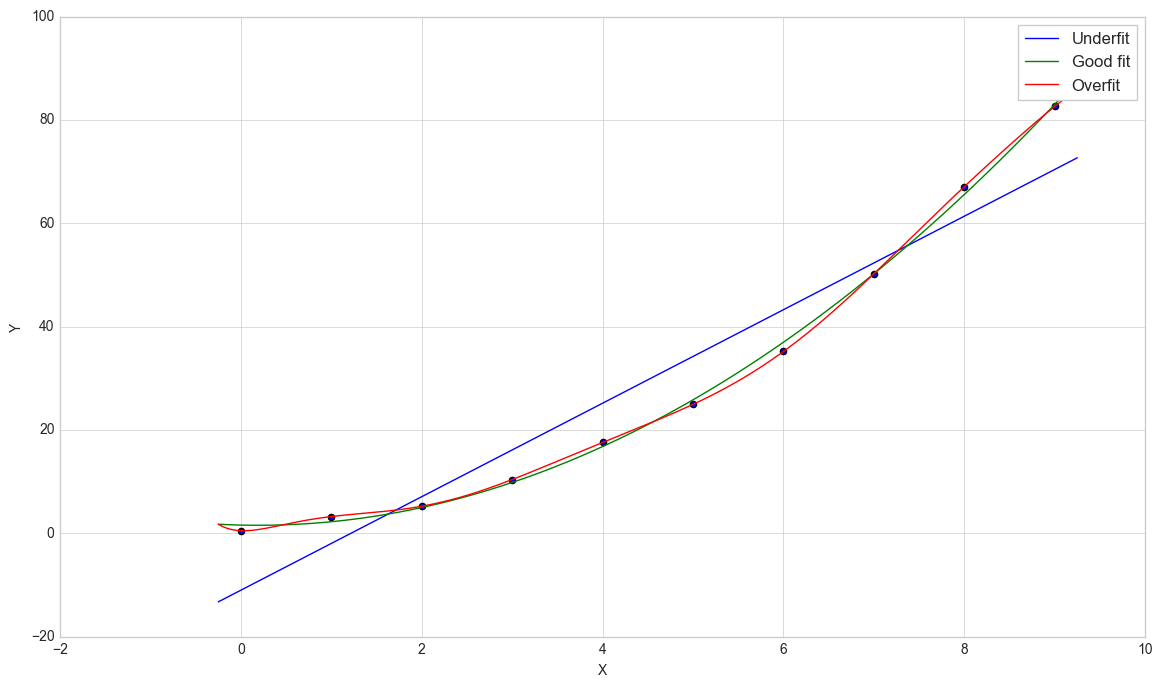

In [15]:
from scipy import poly1d

x = np.arange(10)
y = 2*np.random.randn(10) + x**2
xs = np.linspace(-0.25, 9.25, 200)

lin = np.polyfit(x, y, 1)
quad = np.polyfit(x, y, 2)
many = np.polyfit(x, y, 9)

plt.scatter(x, y)
plt.plot(xs, poly1d(lin)(xs))
plt.plot(xs, poly1d(quad)(xs))
plt.plot(xs, poly1d(many)(xs))
plt.ylabel('Y')
plt.xlabel('X')
plt.legend(['Underfit', 'Good fit', 'Overfit']);

In another example, we try to regress one asset to another in the same sector as an attempt to predict that asset's price, and also to 3 unrelated ones. We should see that while the in-sample data is fitted better with more assets, the MLR fails completely with out-of-sample data.

SLR R-squared: 0.512904965064
SLR p-value: 3.33013685314e-40
MLR R-squared: 0.727710773274
MLR p-value: 1.02375604498e-67


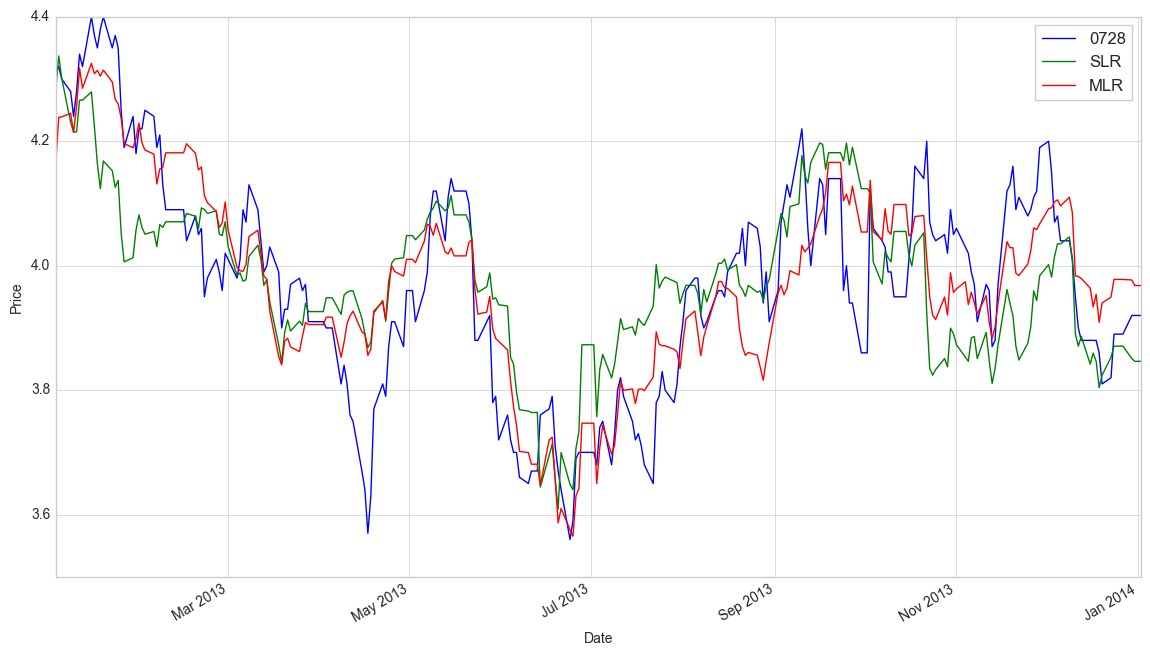

In [31]:
from statsmodels import regression

# Load one year's worth of pricing data for five different assets
start = '2013-01-01'
end = '2014-01-01'
y = ut.get_pricing('0728.HK', src='yhoo', start_date=start, end_date=end, field='close').dropna()
x1 = ut.get_pricing('0941.HK', src='yhoo', start_date=start, end_date=end, field='close').dropna()
x2 = ut.get_pricing('0001.HK', src='yhoo', start_date=start, end_date=end, field='close').dropna()
x3 = ut.get_pricing('0388.HK', src='yhoo', start_date=start, end_date=end, field='close').dropna()
x4 = ut.get_pricing('0386.HK', src='yhoo', start_date=start, end_date=end, field='close').dropna()

# Build a linear model using only x1 to explain y
slr = regression.linear_model.OLS(y, sm.add_constant(x1)).fit()
slr_prediction = slr.params[0] + slr.params[1]*x1

# Run multiple linear regression using x1, x2, x3, x4 to explain y
mlr = regression.linear_model.OLS(y, sm.add_constant(np.column_stack((x1,x2,x3,x4)))).fit()
mlr_prediction = mlr.params[0] + mlr.params[1]*x1 + mlr.params[2]*x2 + mlr.params[3]*x3 + mlr.params[4]*x4

# Compute adjusted R-squared for the two different models
print 'SLR R-squared:', slr.rsquared_adj
print 'SLR p-value:', slr.f_pvalue
print 'MLR R-squared:', mlr.rsquared_adj
print 'MLR p-value:', mlr.f_pvalue

# Plot y along with the two different predictions
y.plot()
slr_prediction.plot()
mlr_prediction.plot()
plt.ylabel('Price')
plt.xlabel('Date')
plt.legend(['0728', 'SLR', 'MLR']);

SLR R-squared: 0.789774136106
MLR R-squared: 0.779845320128


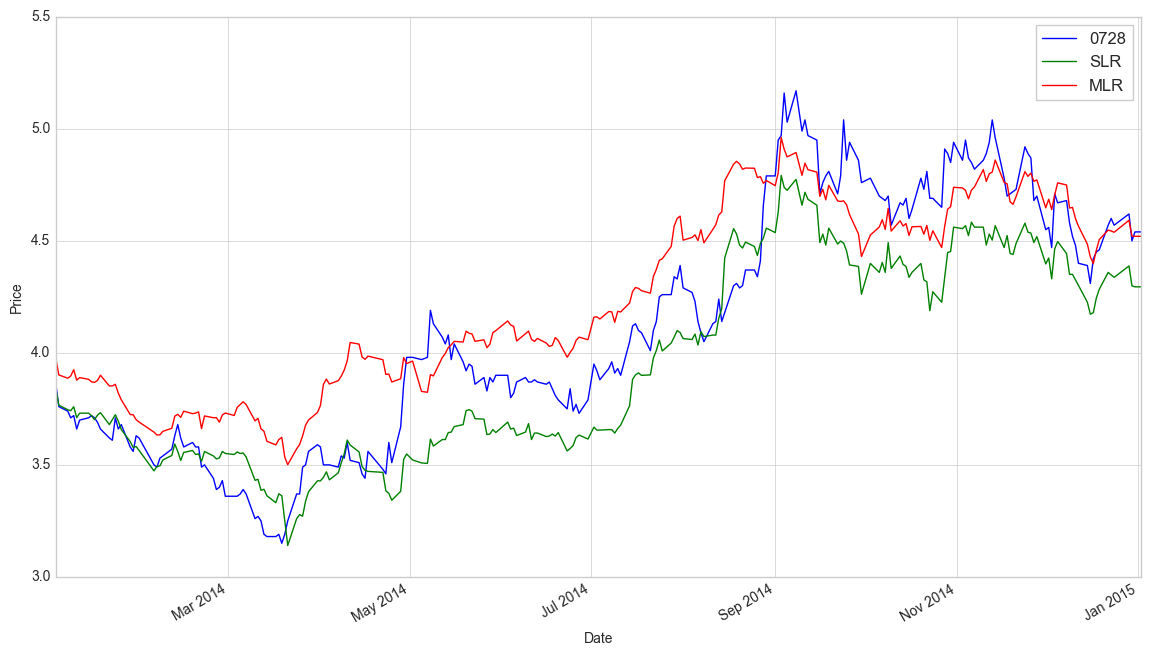

In [32]:
# Load next year's data
start = '2014-01-01'
end = '2015-01-01'
y = ut.get_pricing('0728.HK', src='yhoo', start_date=start, end_date=end, field='close').dropna()
x1 = ut.get_pricing('0941.HK', src='yhoo', start_date=start, end_date=end, field='close').dropna()
x2 = ut.get_pricing('0001.HK', src='yhoo', start_date=start, end_date=end, field='close').dropna()
x3 = ut.get_pricing('0388.HK', src='yhoo', start_date=start, end_date=end, field='close').dropna()
x4 = ut.get_pricing('0386.HK', src='yhoo', start_date=start, end_date=end, field='close').dropna()

# Extend our model from before to the new time period
slr_prediction2 = slr.params[0] + slr.params[1]*x1
mlr_prediction2 = mlr.params[0] + mlr.params[1]*x1 + mlr.params[2]*x2 + mlr.params[3]*x3 + mlr.params[4]*x4

# Manually compute adjusted R-squared over the new time period

# Adjustment 1 is for the SLR model
p = 1
N = len(y)
adj1 = float(N - 1)/(N - p - 1)

# Now for MLR
p = 4
N = len(y)
adj2 = float(N - 1)/(N - p - 1)

SST = sum((y - np.mean(y))**2)
SSRs = sum((slr_prediction2 - y)**2)
print 'SLR R-squared:', 1 - adj1*SSRs/SST
SSRm = sum((mlr_prediction2 - y)**2)
print 'MLR R-squared:', 1 - adj2*SSRm/SST

# Plot y along with the two different predictions
y.plot()
slr_prediction2.plot()
mlr_prediction2.plot()
plt.ylabel('Price')
plt.xlabel('Date')
plt.legend(['0728', 'SLR', 'MLR']);

A common mistake that counts as overfitting is abusing out-of-sample data. Suppose we construct a model on in-sample data, test it on out-of-sample data, and conclude that it does not work. We repeat this process until we find a model that works. This is still overfitting, since by using the out-of-sample data many times, we end up overfitting the model. This leads to our model breaking down when we actually test it on true out-of-sample data.

We can try to avoid overfitting by taking large samples, choosing reasonable and simple models, and not cherry-picking parameters to fit the data.

We can cross-validate: this is the process of splitting your data into n parts, then estimating optimal parameters for n-1 parts combined and testing on the final part. By doing this n times, one for each part held out, we can establish how stable our parameter estimates are and how predictive they are on data not from the original set.

We can also use information criterion, which is a type of statistical test we met before. They favour simpler models and will tell us if we are introducing a large amount of complexity without much return. 

## Stationarity

Data are stationary when the parameters of the data generating process do not change over time. Many statistical tests require data to be stationary. Informally put, a process is stationary if the parameters of the data generating process does not change over time. For example, consider the following series:

In [33]:
from statsmodels.tsa.stattools import coint, adfuller

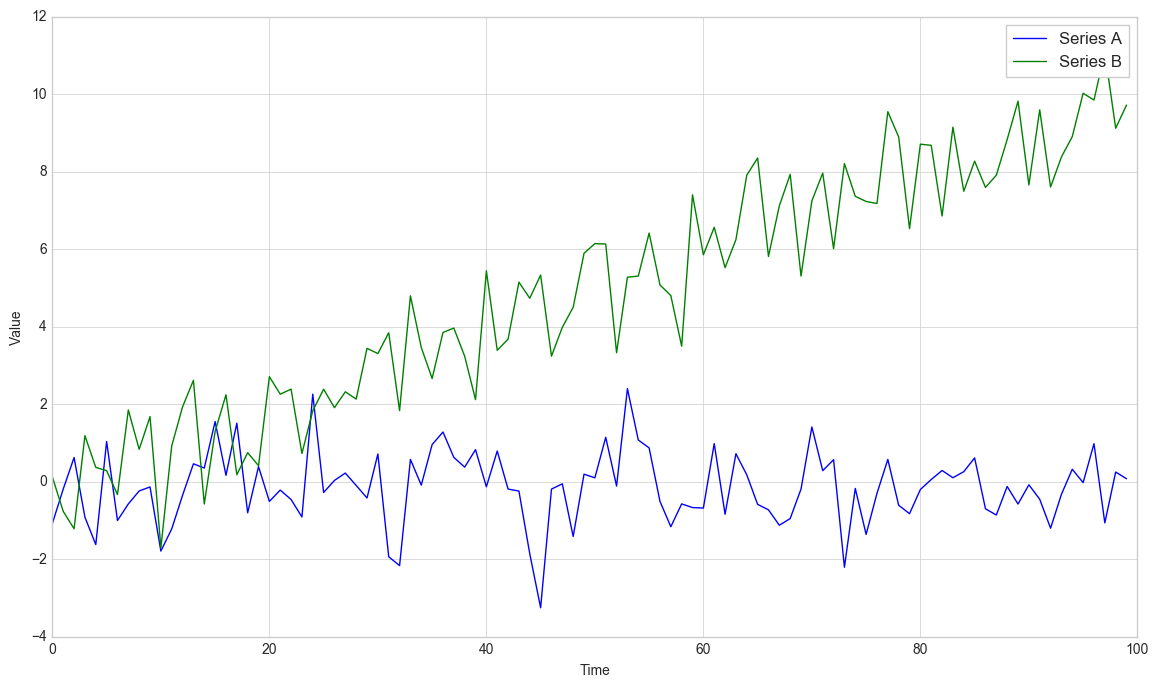

In [34]:
def generate_datapoint(params):
    mu = params[0]
    sigma = params[1]
    return np.random.normal(mu, sigma)

# number of datapoints
T = 100

params = (0, 1)

A = pd.Series(index=range(T))
A.name = 'A'

for t in range(T):
    A[t] = generate_datapoint(params)



B = pd.Series(index=range(T))
B.name = 'B'

for t in range(T):
    # Now the parameters are dependent on time
    # Specifically, the mean of the series changes over time
    params = (t * 0.1, 1)
    B[t] = generate_datapoint(params)

plt.plot(A)
plt.plot(B)
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(['Series A', 'Series B']);

If we try to calculate the mean of the second series, it will obviously give us a meaningless result. Thus, a non-stationary series can be problematic.

The adfuller test allows us to identify non-stationarity.

In [35]:
def check_for_stationarity(X, cutoff=0.01):
    # H_0 in adfuller is unit root exists (non-stationary)
    # We must observe significant p-value to convince ourselves that the series is stationary
    pvalue = adfuller(X)[1]
    if pvalue < cutoff:
        print 'p-value = ' + str(pvalue) + ' The series ' + X.name +' is likely stationary.'
        return True
    else:
        print 'p-value = ' + str(pvalue) + ' The series ' + X.name +' is likely non-stationary.'
        return False

In [36]:
check_for_stationarity(A);
check_for_stationarity(B);

p-value = 7.07925207633e-06 The series A is likely stationary.
p-value = 0.936884899553 The series B is likely non-stationary.


Stationarity is usually more subtle than can be identified visually. In practice on noisy data and limited sample size it can be hard to determine if a series is stationary and whether any drift is random noise or part of a trend. In each individual case the test may or may not pick up subtle effects like this.

p-value = 0.00243872455137 The series C is likely stationary.


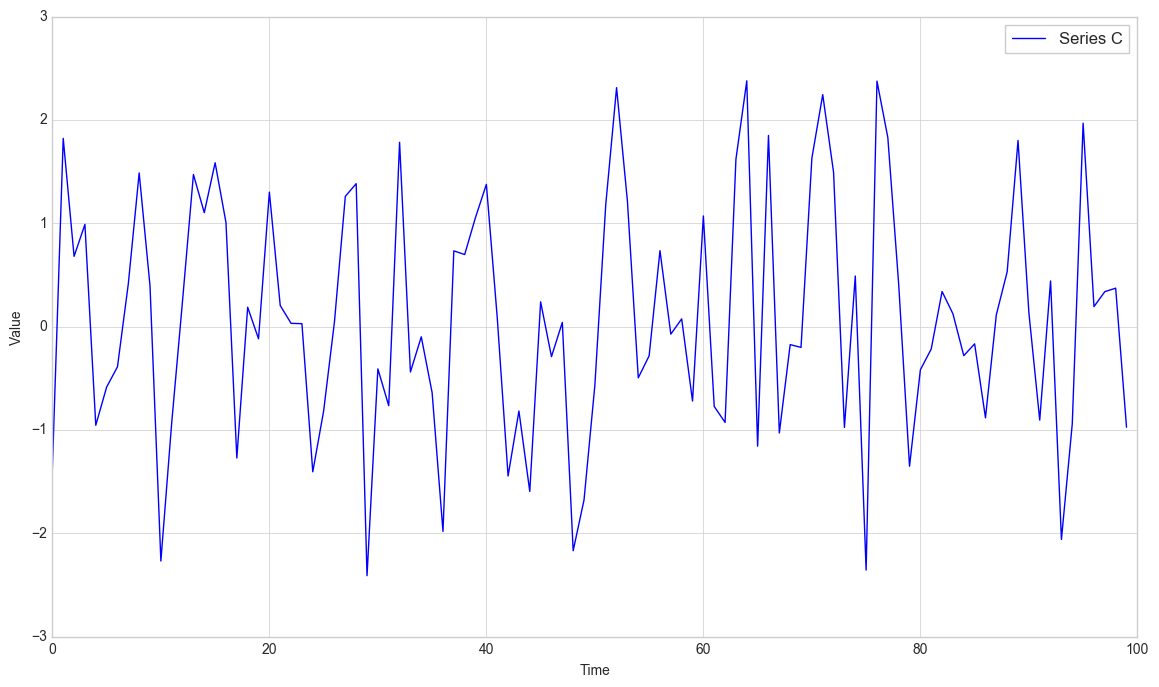

In [37]:
C = pd.Series(index=range(T))
C.name = 'C'

for t in range(T):
    # Now the parameters are dependent on time
    # Specifically, the mean of the series changes over time
    params = (np.sin(t), 1)
    C[t] = generate_datapoint(params)

plt.plot(C)
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(['Series C']);

check_for_stationarity(C);

**Definition** (Stationary process). Let $\{X_t\}$ be a stochastic process and let $F_X(x_{t_1+\tau},...,x_{t_k+\tau})$ represent the cumulative distribution function of the joint distribution of $\{X_t\}$ at times $t_1+\tau,...,t_k+\tau$. Then $\{X_t\}$ is *strictly stationary* if
$$
\forall(k,\tau,t_1,...,t_k):\qquad F_X(x_{t_1+\tau},...,x_{t_k+\tau})=F_X(x_{t_1},...,x_{t_k})\,.
$$

Since $\tau$ does not affect $F_X(\cdot)$, $F_X$ is not a function of time.

Suppose we can now write $\{X_t\}$ as an autoregressive process of order $p$:
$$
X_t=a_1X_{t-1}+a_2X_{t-2}+...+a_pX_{t-p}+\varepsilon_t\,,
$$
where $\varepsilon_t$  is a serially uncorrelated, zero-mean stochastic process with constant variance. Now let $X_0=0$ for convenience. If $m=1$ is a root of the characteristic equation
$$
m^p-m^{p-1}a_1-...a_p=0
$$
then the stochastic process has a unit root.

The adfuller test is a statistical test where its null hypothesis is that the process has a unit root.

**Theorem** (Wold's). For any stationary process $X_t$, there exists a deterministic time series $\eta_t$ and stochastic time series $\varepsilon_t$ s.t.
$$
Y_t=\sum_{j=0}^\infty b_j\varepsilon_{t-j}+\eta_t\,,
$$
where $b$ is the (possibly) infinite vector of moving average weights. This decomposition is also known as a moving average representation of the time series.

This theorem is important as it states that there is an $\varepsilon_t=\hat{X}_t-X_t$ where $\hat{X}$ is the observed process, that is completely unpredictable using information from time before $t$. The $b_j$ states how much previous values of $\varepsilon$ influence $Y_t$.

## Order of Integration

The order of integration $I(d)$ is a summary statistic for a time series.  It reports the minimum number of differences required to obtain a covariance stationary series. 

**Definition** (Integrated of order 0). A time series is *integrated of order 0* if it admits a moving average representation with
$$
\sum_{k=0}^\infty|b_k|^2<\infty\,,
$$
where $b$ are the weights as defined above. This implies that the autocovariance is decaying to 0 sufficiently quickly.

Note that the above equation is a necessary, but not sufficient condition for a stationary process. Therefore, all stationary processes are $I(0)$, but not all $I(0)$ processes are stationary.

**Definition** (Lag operator). For a time series $\{X_t\}$, the lag operator $L$ is defined as
$$
LX_t=X_{t-1}\qquad\forall t>1\,.
$$
Its inverse is simply
$$
L^{-1}X_t=X_{t+1}\,.
$$

**Definition** (Integrated of order $d$). A time series $\{X_t\}$ is integrated of order $d$ if
$$
(1-L)^dX_t
$$
is a stationary process, where $L$ is the lag operator and $1-L$ is the first difference, i.e.
$$(1-L)X_t=X_t-X_{t-1}=\Delta X\,.$$
In other words, a process is integrated to order $d$ if taking repeated differences $d$ times yields a stationary process.

Since we know that $I(0)$ is stationary. We can use the series `A` defined above. To construct $I(1)$, we perform a cumulative sum (equivalent to discrete integration)

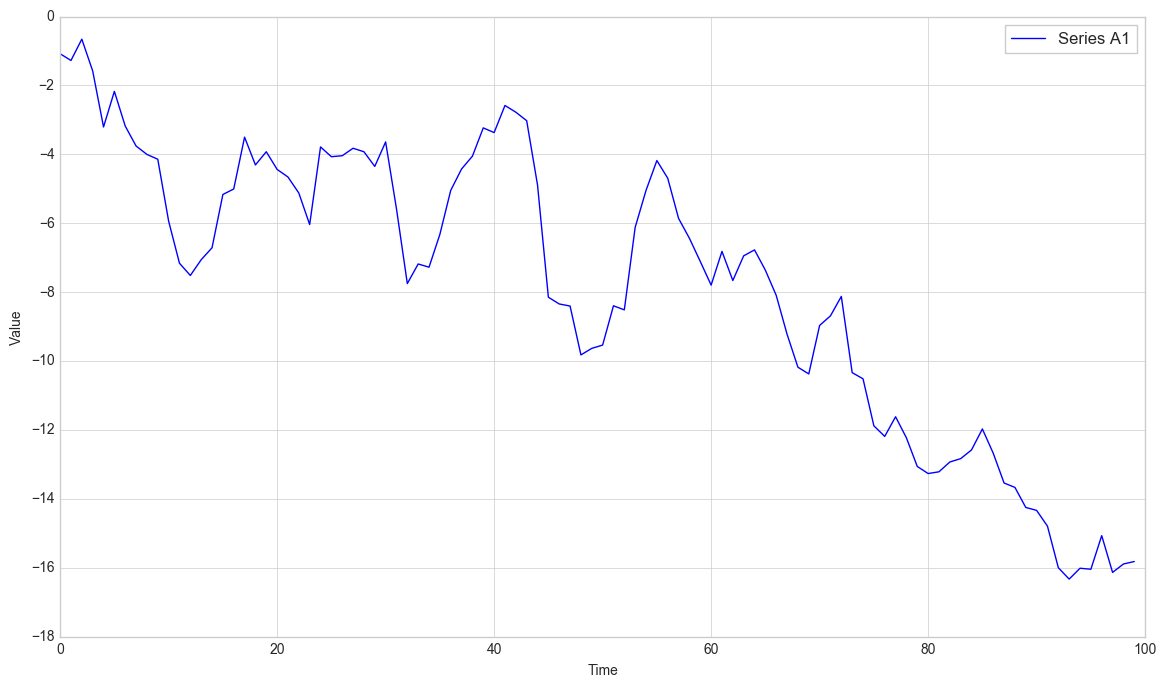

In [38]:
A1 = np.cumsum(A)

plt.plot(A1)
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(['Series A1']);

Similarly to create $I(2)$, we perform a cumulative sum again. To break it down, we use the `diff()` method.

Let us now investigate this on some pricing data. Since stock prices follow a trend, we should expect it to be non-stationary. Stock returns will less likely have this behaviour, and in general should be stationary.

In [39]:
check_for_stationarity(A1);
check_for_stationarity(A1.diff()[1:]);

p-value = 0.849667050378 The series A is likely non-stationary.
p-value = 3.30166795578e-06 The series A is likely stationary.


In [40]:
prices = ut.get_pricing("0005.HK",src='yhoo', start_date='2014-01-01', end_date='2015-01-01', field='close').dropna()

p-value = 0.494234180563 The series 0005.HK is likely non-stationary.


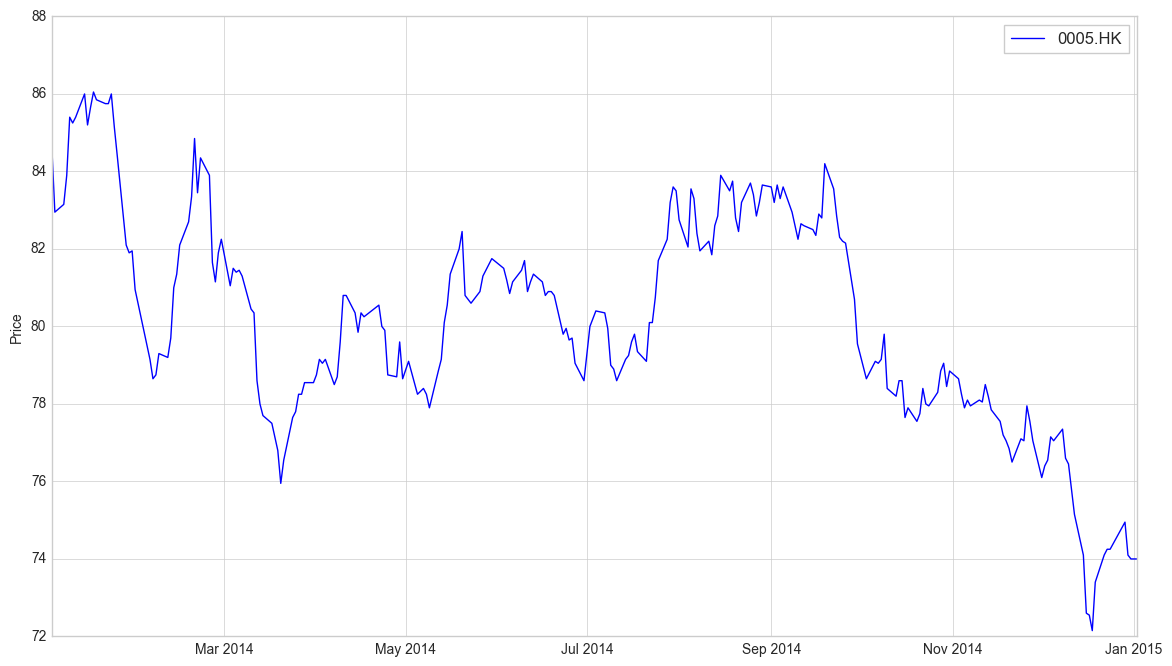

In [41]:
X=prices
check_for_stationarity(X)

plt.plot(X.index, X.values)
plt.ylabel('Price')
plt.legend([X.name]);

p-value = 5.23056257068e-26 The series 0005.HK Additive Returns is likely stationary.


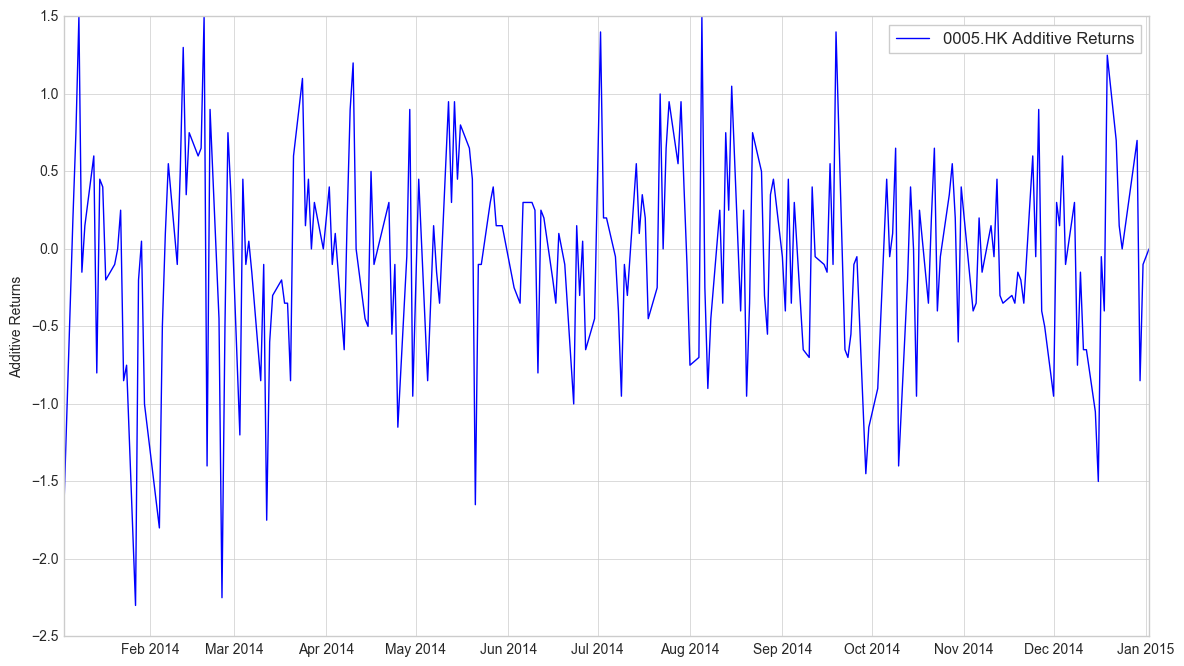

In [42]:
X1 = X.diff()[1:]
X1.name = X.name + ' Additive Returns'
check_for_stationarity(X1)
plt.plot(X1.index, X1.values)
plt.ylabel('Additive Returns')
plt.legend([X1.name]);

p-value = 7.10225151862e-26 The series 0005.HK Multiplicative Returns is likely stationary.


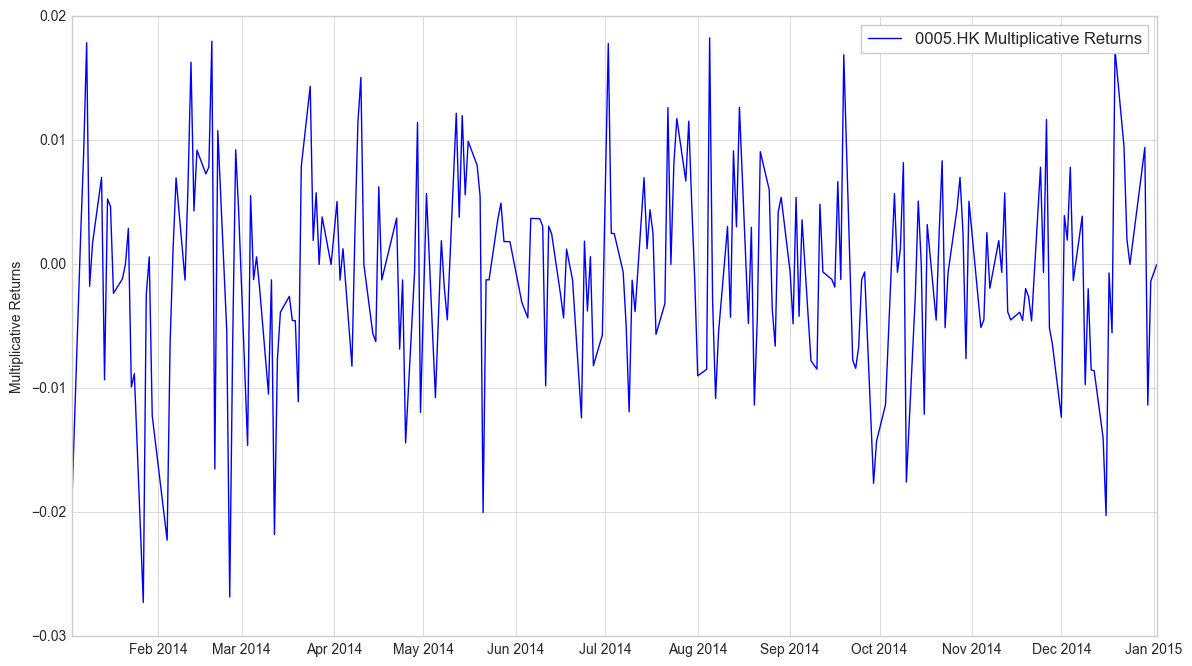

In [43]:
X1 = X.pct_change()[1:]
X1.name = X.name + ' Multiplicative Returns'
check_for_stationarity(X1)
plt.plot(X1.index, X1.values)
plt.ylabel('Multiplicative Returns')
plt.legend([X1.name]);

Hence, the reason why returns are analysed much more in depth than price is due to them being a lot more stationary. Note however that using a returns forecasting model to forecast price can be tricky, as any error in the returns forecast will be magnified over time.

## Cointegration

Cointegration is a statistical property of a collection $(X_1,...,X_k)$ of time-series variables. It is used in e.g. pairs trading.

**Definition** (Linear combination). A linear combination of the time series $(X_1,X_2,...,X_k)$ is a new time-series $Y$ constructed as follows for any set of real numbers $b_1,...,b_k$
$$
Y=b_1X_1+b_2X_2+...+b_kX_k\,.
$$

**Definition** (Cointegration). Let $(X_1,...,X_k)$ be a collection of $I(1)$ time-series variables. This collection is said to be *cointegrated* if there exists a linear combination of them that is $I(0)$.

**Example.** Let $X_1$, $X_2$, $X_3$ be all $I(1)$. Then if $2X_1+ X_2 +0X_3=2X_1+X_2$ is $I(0)$, then the $X_i$ are cointegrated.

This result is useful since if the combination $b_1A_1 +b_2A_2$ is just noise, then any fluctuation will be around a fixed mean which can be easily estimated. The pairs trading strategy then makes use of this by betting against the spreads of the two cointegrated assets.

Let's first simulate some data to see this in action.

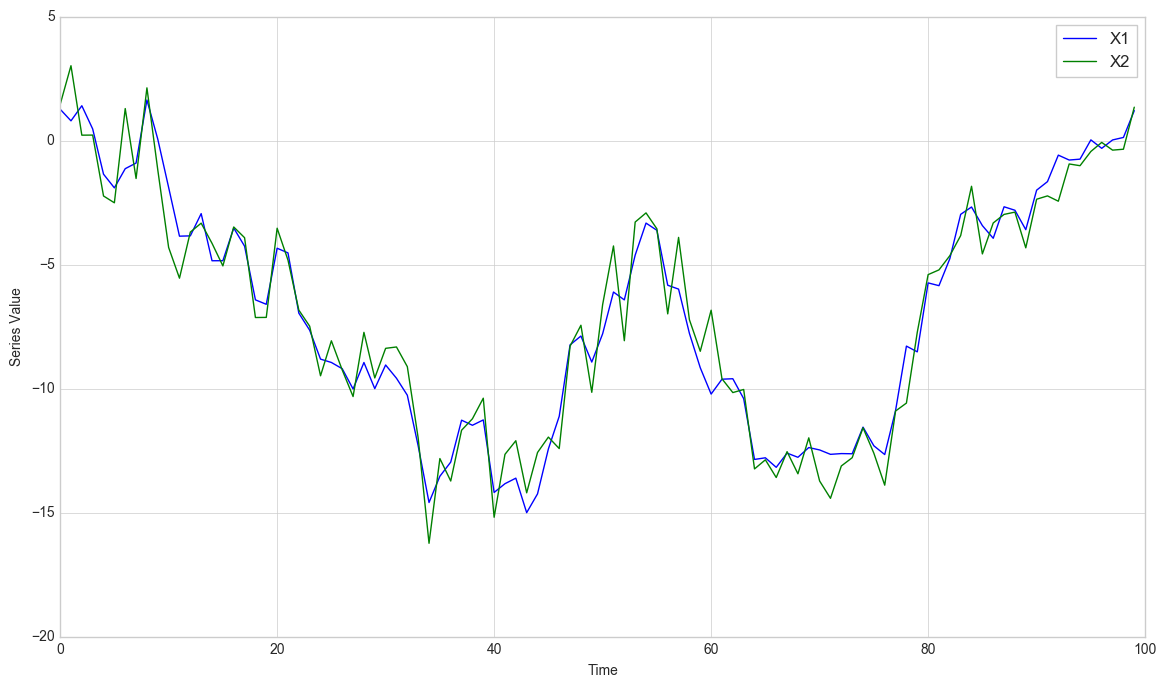

In [44]:
# Length of series
N = 100

# Generate a stationary random X1
X1 = np.random.normal(0, 1, N)
# Integrate it to make it I(1)
X1 = np.cumsum(X1)
X1 = pd.Series(X1)
X1.name = 'X1'

# Make an X2 that is X1 plus some (stationary) noise
X2 = X1 + np.random.normal(0, 1, N)
X2.name = 'X2'

plt.plot(X1)
plt.plot(X2)
plt.xlabel('Time')
plt.ylabel('Series Value')
plt.legend([X1.name, X2.name]);

p-value = 0.130563580772 The series Z is likely non-stationary.


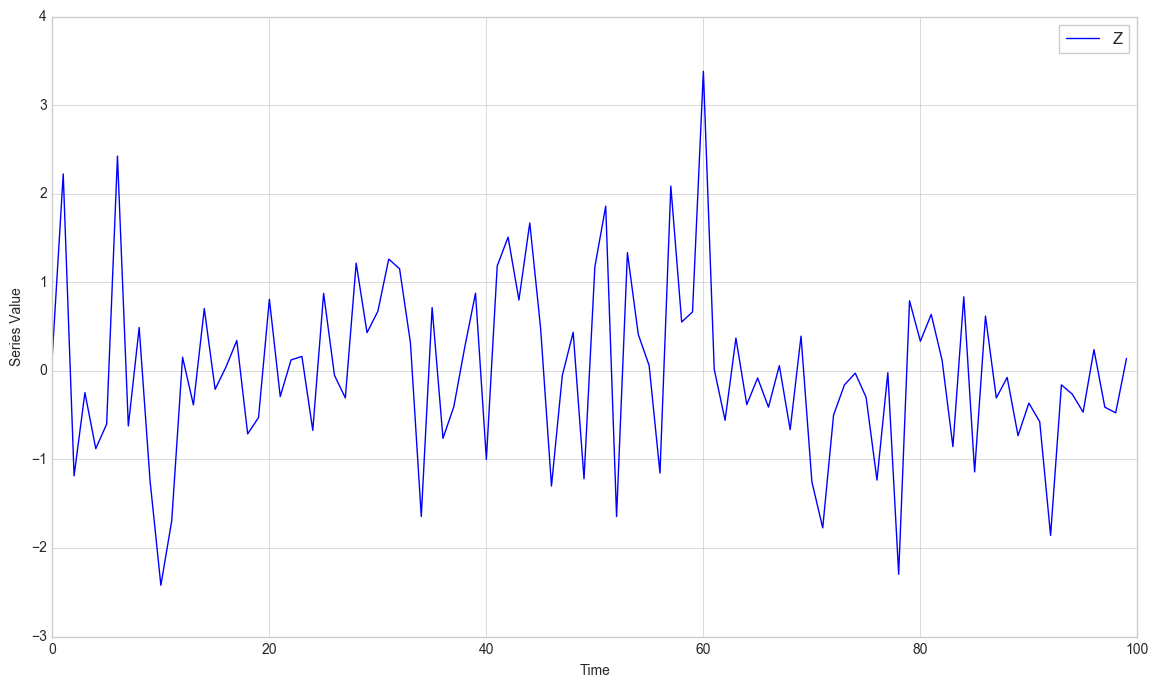

In [45]:
Z = X2 - X1
Z.name = 'Z'

plt.plot(Z)
plt.xlabel('Time')
plt.ylabel('Series Value')
plt.legend(['Z']);

check_for_stationarity(Z);

To test for cointegration, we try to give our best guess for the coefficients $b_1,...,b_k$ that will produce a linear combination that is $I(0)$. If our stationarity check is not passed for these coefficients, then we reject the hypothesis that the test is cointegrated. This will produce a Type II error (false negatives) but is generally safe and will avoid making wrong forecasts.

A common way of doing this is to use linear regression to estimate $\beta$ in the following model:
$$
X_2=\alpha+\beta X_1+\epsilon\,.
$$
If the two are cointegrated, then the combination $X_2-\beta X_1=\alpha+\epsilon$ should be stationary.

In [46]:
symbol_list=['3988.HK','1398.HK']
prices = ut.get_pricing(symbol_list,src='yhoo',start_date='2014-01-01',end_date='2015-01-01',field='close').dropna()

X1 = prices[symbol_list[0]]
X2 = prices[symbol_list[1]]

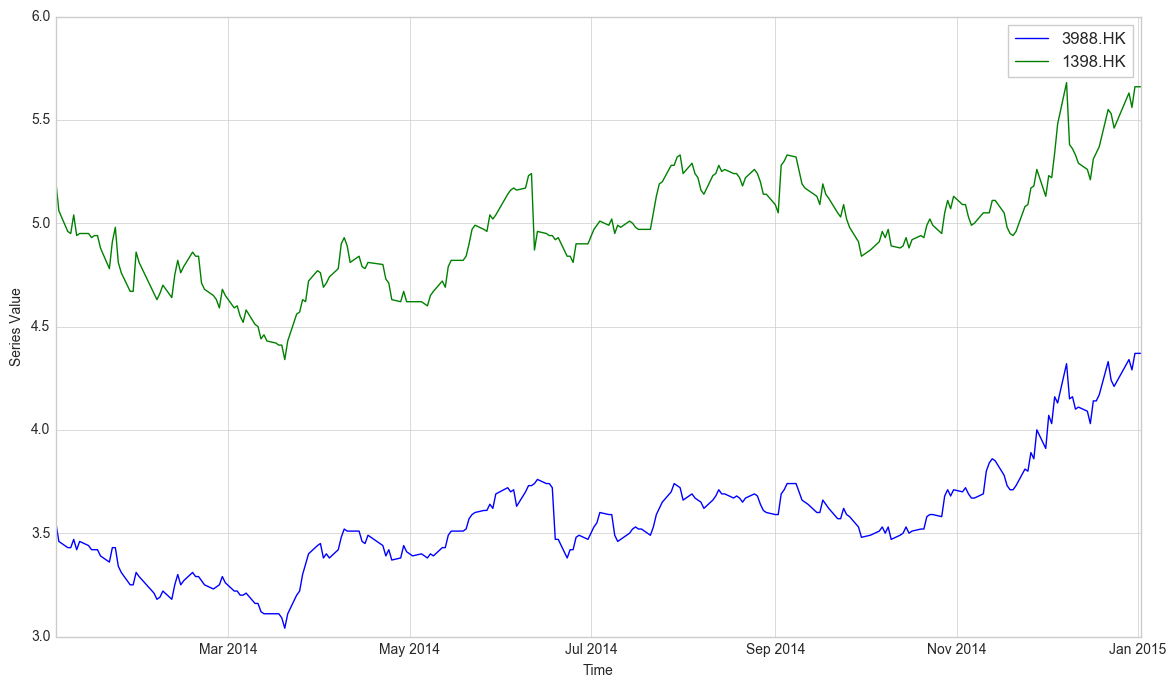

In [47]:
plt.plot(X1.index, X1.values)
plt.plot(X1.index, X2.values)
plt.xlabel('Time')
plt.ylabel('Series Value')
plt.legend([X1.name, X2.name]);

p-value = 0.00417642827172 The series Z is likely stationary.


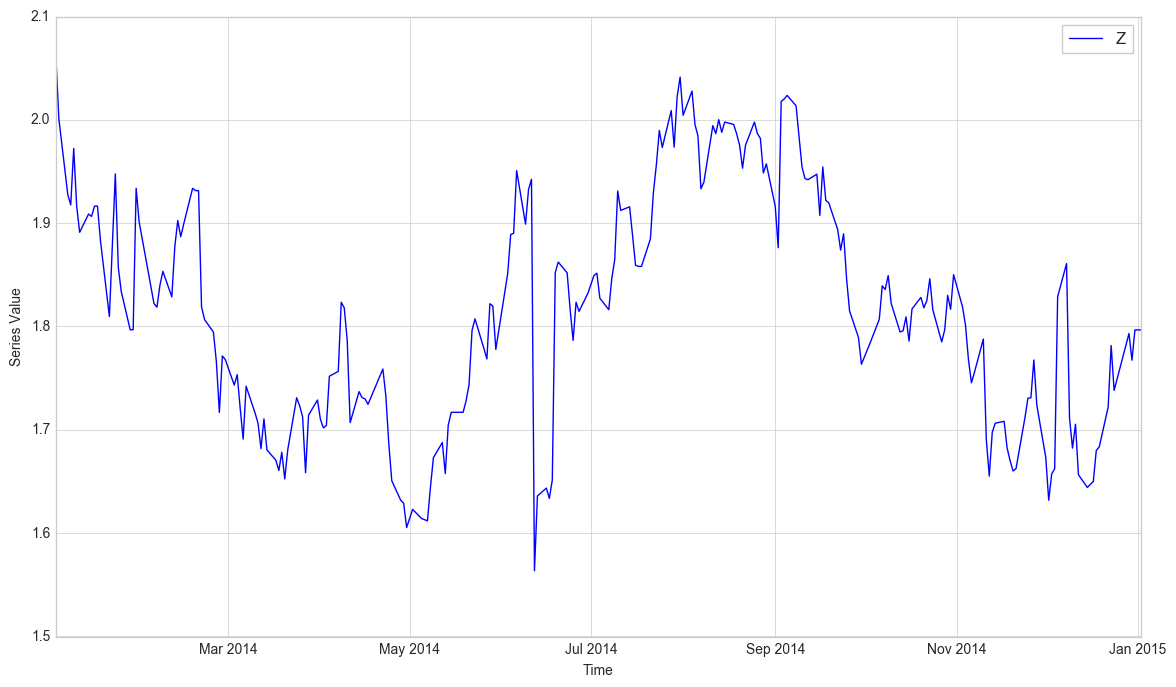

In [48]:
X1 = sm.add_constant(X1)
results = sm.OLS(X2, X1).fit()

# Get rid of the constant column
X1 = X1[symbol_list[0]]

results.params

b = results.params[symbol_list[0]]
Z = X2 - b * X1
Z.name = 'Z'

plt.plot(Z.index, Z.values)
plt.xlabel('Time')
plt.ylabel('Series Value')
plt.legend([Z.name]);

check_for_stationarity(Z);